In [0]:
#########################################################
# Decryption of Enigma coded strings
#########################################################

# -----------------------------------------------------------
# Part of coding challenge for Scale AI ML Role
# Github link: https://github.com/hkhoont/scale_ai_engima_machine
# email: hsk2147@columbia.edu
# -----------------------------------------------------------

In [48]:
# Mounting the drive of User testing this script
from google.colab import drive
drive.mount('/content/drive')
root='/content/drive/My Drive/Applications/# Scale AI/runs/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## A - Installing  and importing libraries

In [49]:
!pip install py-enigma
!pip install faker
!pip install tensorboardX==1.4
!pip install tqdm
!pip install hide_code


In [0]:
import warnings
warnings.filterwarnings("ignore")

from typing import List, Tuple
from enigma.machine import EnigmaMachine
from faker import Faker
import re
import numpy as np
import string
import random
import time
import math
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import functional as F
import collections
from tqdm import tqdm
from tqdm import trange, tqdm
from time import sleep

## B - Helper functions already provided

In [0]:
class ConfiguredMachine:
    def __init__(self):
        self.machine = EnigmaMachine.from_key_sheet(
            rotors='II IV V',
            reflector='B',
            ring_settings=[1, 20, 11],
            plugboard_settings='AV BS CG DL FU HZ IN KM OW RX')

    def reset(self):
        self.machine.set_display('WXC')

    def encode(self, plain_str: str) -> str:
        self.reset()
        return self.machine.process_text(plain_str)

    def batch_encode(self, plain_list: List[str]) -> List[str]:
        encoded = list()
        for s in plain_list:
            encoded.append(self.encode(s))
        return encoded

In [0]:
def pre_process(input_str):
    return re.sub('[^a-zA-Z]', '', input_str).upper()


def generate_data(batch_size: int, seq_len: int = 42) -> Tuple[List[str], List[str]]:
    fake = Faker()
    machine = ConfiguredMachine()

    plain_list = fake.texts(nb_texts=batch_size, max_nb_chars=seq_len)
    plain_list = [pre_process(p) for p in plain_list]
    cipher_list = machine.batch_encode(plain_list)
    return plain_list, cipher_list


def predict(cipher_list: List[str]) -> List[str]:
    """
    Solution
    Input: Plain string with length <42
    Output: Decryption of the string according to Enigma machine(as configured above). Size of decryption should be same as input string
    """
    return cipher_list


def str_score(str_a: str, str_b: str) -> float:
    if len(str_a) != len(str_b):
        return 0
    n_correct = 0
    for a, b in zip(str_a, str_b):
        n_correct += int(a == b)
    return n_correct / len(str_a)

def score(predicted_plain: List[str], correct_plain: List[str]) -> float:
    correct = 0
    for p, c in zip(predicted_plain, correct_plain):
        if str_score(p, c) > 0.8:
            correct += 1
    return correct / len(correct_plain)

## C - Data Exploration

In [0]:
plain, cipher = generate_data(32)

In [54]:
plain[:5]

['WINGUNNORTHTREATENOUGHKID',
 'SYSTEMSORTKEEPLOSEDRAWCHALLENGE',
 'BEHINDTHEYTHOUGHGOOD',
 'BAGDOFOURMARKETNEWSLOCALEAST',
 'HARDALWAYSWHENALMOSTGIRLAGENT']

In [55]:
cipher[:5]

['IFPFBKYHZOZPMOKCUANMXPUGM',
 'UKLOCPDHZOAOBMHALLASHMSXUDHHMAN',
 'KAAAYGVOCMEMQTYVQKNP',
 'KEYCTSAJZYKBWOXYUDMQTIJAIJYK',
 'GEXCLUEPTNGMBQKFOKMHXCPAUPGVQ']

- The decryption of the first letter remains same for a particular varibale.
- Therefore, there is no need to learn the key for the message becuase the Enigma machine is already set to a particular configuration
- The data generated does not need any data cleaning and pre-preocessing since it is perfect simulated data

## D - Data vectorizing

In [0]:
all_characters = "#ABCDEFGHIJKLMNOPQRSTUVWXYZ"
vocab = {}
for i,char in enumerate(all_characters):
    vocab[i]=char

n_characters = len(all_characters)

### D.1 Turning a string into a tensor

In [0]:
# Turning a string into a tensor
def string_to_tensor(string):
    """
    Convert string into numerical torch tensor filled with index according to above mentioned 'all_characters' variable
    Input: String of capital letters to be dencrypted 
    Output: Torch tensor(torch.size(42)) 
    """
    tensor = torch.zeros(42).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor

In [0]:
# Readable time elapsed
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
def batch_tensor(batch_size):
    """
    This the main generater function
    Input: Batch_size (generally 2^n)
    Output 1: Tensor of text batch padded with zero: Size=torch.size(batch_size,42)
    Output 2: Tensor of decryption of same batch padded with zero: Size=torch.size(batch_size,42)
    Output 3: Tensor of string sizes: Size=torch.size(batch_size)
    Output 4: List of Strings: len(plain)=batch_size
    """
    plain, cipher = generate_data(batch_size)                                   #Generates random strings and its decryption
    x_length = []
    for i in plain:
        x_length.append(len(i))
    string_length = 42
    x = torch.LongTensor(batch_size, string_length)
    y = torch.LongTensor(batch_size, string_length)

    for i in range(batch_size):
        y[i] = string_to_tensor(plain[i])
        x[i] = string_to_tensor(cipher[i])
    x = Variable(x)
    y = Variable(y)
    return x.long(),y.long(),torch.FloatTensor(x_length),plain

## E - Model Building

- We will try to model this problem character by character prediction
- Since the decryption of a particular character depends on the previous character and its decryption. 
- Such a situation is ideally modeled using sequence to sequence neural networks
- These networks range from deep RNN, GRU, LSTM to deep attention based Encoder-Decoder models
- Attention-based networks have been proved to a lot better than other encoder-decoder networks
- These networks are capable of capturing complex sequential patterns where the next symbol is partially determined by events that happened many time steps in the past.

## F - Model Architecture
- The following are the criteria used to pick the best network: 
    - Engima decryption is highly dependent if you can learn the key formating in the machine. 
    - These keys are distributed in advance, which gives the initial configuration of the machine to decrypt the message
    - Key list here is pre-defined in the `config` function
- But with a constraint on ***Number of parameters<60K (Capacity of the network)***, 
    - Stacked LSTM is a good choice 
    - First, considering the learned key format in latent variables would be used throughout the decryption of the string
    - Second, LSTM handles vanishing gradient problem much better than similar networks RNN and GRU units

In [0]:
class CharLSTM(nn.Module):
    def __init__(self, input_size, hidden_size,output_size, n_layers):
        super(CharLSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        padding_idx = 0

        # Encoder embedding layer is used to convert batch text in one-hot encode form
        # Since its one-hot encoded (vocal size = 27), there no need to learn the embeddings
        self.encoder = nn.Embedding(num_embeddings=self.input_size,
                                    embedding_dim=self.input_size,
                                    padding_idx=padding_idx,)
        self.encoder.weight.data = torch.eye(self.input_size)
        self.encoder.weight.requires_grad = False

        # LSTM Unit
        self.lstm = nn.LSTM(self.input_size, 
                           hidden_size, 
                           n_layers, 
                           batch_first=True)
        
        #Decoder
        self.decoder = nn.Linear(hidden_size, 
                                 output_size)
        
    def forward(self, x, x_length):

        # print("Max in x_length",max(x_length))
        batch_size_input = x_length.shape[0]
        self.hidden = self.init_hidden(batch_size_input)                        # Initialize the weights
        x = self.encoder(x)                                                     # Encoder

        # print("/CharLSTM/forward/ Size: x after encoder - ",x.shape)

        #Pack Padding will ensure that forward pass is carried for only units equal to length of string 
        x = torch.nn.utils.rnn.pack_padded_sequence(x, 
                                                    x_length, 
                                                    batch_first=True,
                                                    enforce_sorted=False)
        
        x, self.hidden = self.lstm(x, self.hidden)                              # Running the LSTM Unit
        x, _ = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)

        # print("/CharLSTM/forward/ Size: x after pad - ",x.shape)

        x = x.contiguous()
        x = x.view(-1, x.shape[2])
        # print("/CharLSTM/forward/ Size: x after view - ",x.shape)
        x = self.decoder(x)                                                     # Decoder
        # print("/CharLSTM/forward/ Size: x after decoder - ",x.shape)
        x = F.log_softmax(x, dim=1)
        # x = F.softmax(x, dim=1)

        Y_hat = x
        return Y_hat


    def init_hidden(self,batch_size_input):
        """
        Initial the weights
        Method: Random
        """
        hidden_a = torch.randn(self.n_layers,batch_size_input, self.hidden_size)
        hidden_b = torch.randn(self.n_layers,batch_size_input, self.hidden_size)

        hidden_a = Variable(hidden_a)
        hidden_b = Variable(hidden_b)

        return (hidden_a, hidden_b)

## G - Cross Entropy Loss
- Since the size of each string is different, the output prediction should be padded with zeros
- Inbuilt cross-entropy function is not suitable here because of the difference in shapes of `Y_hat` and `Y`

In [0]:
def criterion(Y_hat, Y, X_lengths,batch_size):
    """
    Custom defined Cross entropy Function (Objective function calculation)
    Input 1: Tensor of prediction of a batch of data: Size=torch.size(batch_size,m,n_characters)
    Input 2: Tensor of groud truth of a batch of data: Size=torch.size(batch_size,42,n_characters)
    Input 3: Tensor of string sizes: Size=torch.size(batch_size)
    Ouput: Single digit tensor - cross entropy loss
    """
    m = int(max(X_lengths).detach())
    Y_hat = Y_hat.view(batch_size,m,input_size)
    # print("/criterion/ Size: Y_hat after view - ",Y_hat.shape)
    # print("/criterion/ Check the sum of softmax==1 - ",torch.sum(Y_hat[0,0,:]))

    # npad is a tuple of 2*len(n_before, n_after) for each dimension
    Y_hat = F.pad(input=Y_hat, pad=(0, 0, 0, 42-m,0,0), mode='constant', value=0)
    # print("/criterion/ Size: Y_hat after padding - ",Y_hat.shape)

    one_hot_encoder = nn.Embedding(num_embeddings=input_size,
                                embedding_dim=input_size)
    one_hot_encoder.weight.data = torch.eye(input_size)
    one_hot_encoder.weight.requires_grad = False
    Y = one_hot_encoder(Y)
    # print("/criterion/ Size: Y after nn.embeddings - ",Y.shape)


    Y = Y.view(-1)
    Y_hat = Y_hat.view(-1)
    total_char = int(torch.sum(Y))
    ce_loss = Y*Y_hat
    # print("/criterion/ Dimension of Ce_loss",ce_loss.shape)
    ce_loss = -torch.sum(ce_loss) / total_char
    return ce_loss

## H - Model function

In [0]:
def model(params):
    """
    Builts model with given hyperparamters
    Input: Dictionary of Hyperparamters. Here I am considering 3 hyperparameters: Number of layers, hidden size and batch size
    Output1: LSTM model
    Output2: Adam optimizer
    Output3: Learning rate scheduler
    """
    # Hyperparameters
    input_size = 27
    output_size = 27
    n_characters=27
    hidden_size = params['hiddensize']
    n_layers = params['nlayers']
    batch_size = params['batchsize']
    learning_rate=0.01

    # model
    final_model = CharLSTM(input_size,
                          hidden_size, 
                          output_size,
                          n_layers)

    # Adam Optimizer with learning rate scheduler
    optimizer = torch.optim.Adam(final_model.parameters(), lr=learning_rate,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.99, last_epoch=-1)
    return final_model,optimizer,scheduler

## I - Printing Model and its paramters

In [0]:
def printing_model(model):
    """
    Prints different characteristics of the LSTM Model
    """
    print("Printing Model")
    print(model)
    print('-'*160)
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print("Number of Paramters: ",pytorch_total_params)
    print('-'*160)
    for i in range(len(list(model.parameters()))):
        print(list(model.parameters())[i].size())
    print('-'*160)

## J - Save computational graph for Tensorboard Visualization

In [0]:
from torch.utils.tensorboard import SummaryWriter
def save_graph(root,model,batch_size):
    """
    Saving computational graph for visualization in TensorBoard
    
    """
    
    x1,y1,x_length1,_ = batch_tensor(batch_size)
    writer = SummaryWriter(root)
    writer.add_graph(model,input_to_model=(x1,x_length1),verbose=True)
    writer.close()
    print('-'*160)
    return writer

## K - Functions of Score and Accuracy calcultions

### K.1 - Accuracy at character level

In [0]:
def string_accuracy(predicted_plain: List[str], correct_plain: List[str],x_length) -> float:
    x_length_array = x_length.detach().numpy().astype('int') 
    correct = 0
    for p, c in zip(predicted_plain, correct_plain):
        for k in range(len(p)):
            if p[k]==c[k]:
                correct = correct +1
    return correct / sum(x_length_array)

### K.2 - Converts one-hot prediction output to Strings

In [0]:
import numpy as np
def numerical_string(batch_size,y_pred,y_batch_string,x_length):
    x_length_array = x_length.detach().numpy().astype('int') 
    m = max(x_length_array)
    y_pred = y_pred.view(batch_size,m,input_size)
    n_y_pred = []

    for k in range(batch_size):
        string_pred = "" 
        for i in range(x_length_array[k]):
            string_pred = string_pred+vocab[np.argmax(y_pred[k][i].detach().numpy())]

        n_y_pred.append(string_pred)

    return n_y_pred,y_batch_string

## L - Training function

In [0]:
def train(final_model, Iteration, batch_size,loss_fn, optimizer,writer_comment):
    iter = 0
    overall_accuracy = 0
    char_accuracy = 0
    running_metric = collections.deque(16*[2], 16)
    running_character_accuracy = collections.deque(8*[0], 8)
    for iter in range(Iteration):

        x,y,x_length,plain = batch_tensor(batch_size)

        Y_hat = final_model(x,x_length)

        # print("/train/ Shape: Y_hat - ",Y_hat.shape)
        # print(/train/ Shape: y",y.shape)
        final_model.zero_grad()
        loss = loss_fn(Y_hat, y, x_length,batch_size)
        batch_accuracy = score(*numerical_string(batch_size,Y_hat,plain,x_length))
        loss.backward()
        optimizer.step()
        batch_accuracy = score(*numerical_string(batch_size,Y_hat,plain,x_length))
        char_accuracy = (char_accuracy*iter+string_accuracy(*numerical_string(batch_size,Y_hat,plain,x_length),x_length))/(iter+1)

        overall_accuracy = (overall_accuracy*iter+batch_accuracy)/(iter+1)

        if iter % 20 == 0:
  
            test_x,test_y,test_x_length,test_plain = batch_tensor(batch_size)
            y_hat_test = final_model(test_x,test_x_length)
            loss_test = loss_fn(y_hat_test, test_y, test_x_length,batch_size)

            batch_accuracy = score(*numerical_string(batch_size,Y_hat,plain,x_length))
            batch_accuracy_test = score(*numerical_string(batch_size,y_hat_test,test_plain,test_x_length))


            char_accuracy_test = string_accuracy(*numerical_string(batch_size,y_hat_test,test_plain,test_x_length),test_x_length)

            writer.add_scalars(writer_comment+' Running Cross Entropy loss',
                              {
                                  "Training":loss,
                                  "Test":loss_test
                              },
                              iter)
            running_metric.append(loss)
            running_metric.append(loss_test)
            writer.add_scalars(writer_comment+' Running Batch Accuracy',
                              {
                                  "Training":batch_accuracy,
                                  "Test":batch_accuracy_test
                              },
                              iter)
            
            writer.add_scalars(writer_comment+' Character Accuracy',
                              {
                                  "Training":char_accuracy,
                                  "Test":char_accuracy_test
                              },
                              iter)
            running_character_accuracy.append(char_accuracy_test)
            writer.add_scalar(writer_comment+' Overall Accuracy',
                              overall_accuracy,
                              iter)


            # Print Loss
            print('Iteration:{:>4} || Cross Entropy loss- Train: {:04.3f} Test: {:04.3f} || Batch Score- Train: {:5.1f}% Test: {:5.1f}% || Cumulative Score {:5.1f}% || Character_accuracy - Train(cumulative): {:5.1f}%   Test: {:5.1f}% '.format(iter, loss,loss_test,batch_accuracy*100.0,batch_accuracy_test*100.0,overall_accuracy*100.0,char_accuracy*100.0,char_accuracy_test*100.0))
        
            if sum(running_metric) / len(running_metric)<0.09:
                print('-'*160)
                print("Stopping Condition Achieved: Average of Last 16 (2*8) Cross entropy Loss is less than 0.09: ",sum(running_metric) / len(running_metric))
                print('-'*160)
                return sum(running_character_accuracy) / len(running_character_accuracy)

            if sum(running_metric) / len(running_metric)>1.3 and iter>1000:
                print('-'*160)
                print("The model with current paramters is not converging in first 1000 iterations: ",sum(running_metric) / len(running_metric))
                print('-'*160)
                return sum(running_character_accuracy) / len(running_character_accuracy)

            if sum(running_metric) / len(running_metric)>0.5 and iter>2000:
                print('-'*160)
                print("The model with current paramters is not converging in first 2000 iterations: ",sum(running_metric) / len(running_metric))
                print('-'*160)
                return sum(running_character_accuracy) / len(running_character_accuracy)

            if iter>4400 or iter==(Iteration-1):
                print('-'*160)
                print("The model with current paramters is not converging: ",sum(running_metric) / len(running_metric))
                print('-'*160)
                return sum(running_character_accuracy) / len(running_character_accuracy)
        if iter%50==0:
            scheduler.step()

        time.sleep(0.1)

## M - Actual model training for a set of paramters and Backpropogation through time

### M.1 Model variables

In [0]:
param_dict={  
        'hiddensize':64,
        'nlayers':2,
        'batchsize':32,
}
input_size = 27
output_size = 27
n_characters=27
hidden_size = param_dict['hiddensize']
n_layers = param_dict['nlayers']
batch_size = param_dict['batchsize']
learning_rate=0.01
comment ='layers'+str(n_layers)+'_hiddensize'+str(hidden_size)+'_batchsize'+str(batch_size)
path = root+comment+'_saved_model.pth'

### M.2 Model Training

In [69]:
final_model,optimizer,scheduler = model(param_dict)

printing_model(final_model)

writer = save_graph(root,final_model,batch_size)


character_acc = train(final_model, 5000, batch_size,criterion, optimizer,comment)
print(character_acc)
torch.save(final_model, path)

Printing Model
CharLSTM(
  (encoder): Embedding(27, 27, padding_idx=0)
  (lstm): LSTM(27, 64, num_layers=2, batch_first=True)
  (decoder): Linear(in_features=64, out_features=27, bias=True)
)
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Paramters:  59572
----------------------------------------------------------------------------------------------------------------------------------------------------------------
torch.Size([27, 27])
torch.Size([256, 27])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([256, 64])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([27, 64])
torch.Size([27])
----------------------------------------------------------------------------------------------------------------------------------------------------------------
graph(%self : ClassType<CharLSTM>,
      %input.1 : Long(32, 42),
      %x_len

## M - Testing on 16384 string messages

In [0]:
# Train Data loader
testing_batch_size = 64
test_exp = int(16384/testing_batch_size)+1
batch_score_test = []

for i in range(test_exp):
    x,y,length,a=batch_tensor(testing_batch_size)
    y_pred=final_model(x,length)
    batch_score_test.append(score(*numerical_string(testing_batch_size,y_pred,a,length)))
batch_score_test = np.array(batch_score_test)
writer.close()

In [72]:
print(batch_score_test.mean(),batch_score_test.std())

0.9936770428015564 0.010218349549686036


In [73]:
batch_score_test[np.where( batch_score_test < 0.95 )]

array([], dtype=float64)

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [0]:
sns.set(color_codes=True)

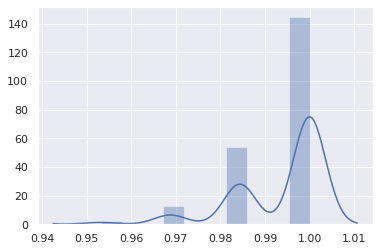

In [76]:
sns.distplot(batch_score_test)

- The average of accuracies of all these batches would be Normal Distribution
    - Parameters of this Normal distribution
        - Mean: Average of accuracies
        - Variance: Sample Variance/(Number of batches)  

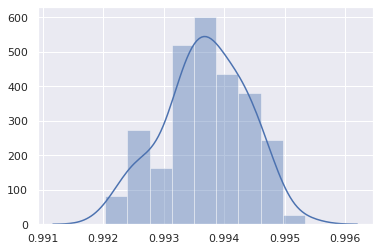

In [77]:
import math
mean = batch_score_test.mean()
std = (batch_score_test.std())/math.sqrt(test_exp)
x = np.random.normal(loc=mean,scale=std,size=100)
sns.distplot(x)

In [78]:
import scipy.stats as st
100 - st.norm.cdf((0.9-mean)/std)*100

100.0

In [79]:
(0.9-mean)/std

-146.96671237206928

- This suggests that the current model gives an accuracy of more than 90% almost every time. 
- The one-tail hypothesis test on the average of accuracies gives (100-$\epsilon$)% confidence (In reality it can't be 100%)
- Here it is rounded because the precision required is beyond the capability of scipy.stats functions)

## N - Model visualization in Tensorboard
- Download the log files form the [link](https://drive.google.com/open?id=17WO-mzmo754fUaYQYuDFkP-EZv_W0kKj) and run it on local Tensorboard
- Log files and visualization are also uploaded to Git Repo

# Appendix - Bayesian Optimization
## Hyperparameter tuning
Popularly there are 3 techniques to optimize hyperparameters of the model
- **Grid Search**
    - High computation is required, especially when the grid becomes higher-dimensional. 
    - It does not consider any improvements over any parameters to anchor the tuning. 
    - Brute force method
- **Random Search**
    - Many times random search gives better result
    - However, this is too random for the conclusion and hope for the best parameters
    - It becomes difficult when the number of hyperparameters increases
- **Bayesian Optimization**
    - Bayesian Optimization based on Gaussian process
    - [Tutorial on Bayesian Optimization](https://arxiv.org/pdf/1012.2599.pdf)

In [61]:
!pip install hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample
import random
import seaborn as sns
import time

In [0]:
param_hyperopt= {
    'hiddensize': hp.choice('hiddensize',[8,16,32,64]),
    'nlayers': hp.choice('nlayers',[1,2,3]),
    'batchsize': hp.choice('batchsize',[8,16,32,64]),
}

In [0]:
def hyperopt(param_space,num_eval):
    
    start = time.time()
    
    def objective_function(params):
        final_model,optimizer,scheduler = model(params)
        input_size = 27
        output_size = 27
        n_characters=27
        hidden_size = params['hiddensize']
        n_layers = params['nlayers']
        batch_size = params['batchsize']
        learning_rate=0.01


        printing_model(final_model)
        comment ='layers'+str(n_layers)+'_hiddensize'+str(hidden_size)+'_batchsize'+str(batch_size)
        hyopt_score = train(final_model, 5000, batch_size,criterion, optimizer,comment)
        return {'loss': -hyopt_score, 'status': STATUS_OK}

    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials,
                      rstate= np.random.RandomState(1))
    
    loss = [x['result']['loss'] for x in trials.trials]
    print(best_param)

    print("Results")
    print("Best Character Accuracy: ", min(loss)*-1)
    print("Best parameters: ", best_param)

    
    return best_param

In [67]:
best_param = hyperopt(param_hyperopt,10)

Printing Model
CharLSTM(
  (encoder): Embedding(27, 27, padding_idx=0)
  (lstm): LSTM(27, 8, batch_first=True)
  (decoder): Linear(in_features=8, out_features=27, bias=True)
)
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Paramters: 
2156
----------------------------------------------------------------------------------------------------------------------------------------------------------------
torch.Size([27, 27])
torch.Size([32, 27])
torch.Size([32, 8])
torch.Size([32])
torch.Size([32])
torch.Size([27, 8])
torch.Size([27])
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Iteration:   0 || Cross Entropy loss- Train: 2.543 Test: 2.690 || Batch Score- Train:   0.0% Test:   0.0% || Cumulative Score   0.0% || Character_accuracy - Train(cumulative):   0.0

TypeError: ignored